<h1><center>Final Project</center></h1>
<h3><center>Zining Wang, Wenxuan Wang, Wenda Zheng</center></h3>   

First, we read and preprocess the data:

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
train.head()


print train.shape



# Adjust House Price based on CPI index, Convert to 2010 December dollars (CPI indices are from Bureau of Labor Statistics)
train.ix[(train.YrSold == 2010) & 
         ((train.MoSold == 7)|(train.MoSold == 6)|(train.MoSold <= 4)),
         'SalePrice'] = train.SalePrice * 1.01
train.ix[(train.YrSold == 2009) & 
         ((train.MoSold == 1)|(train.MoSold == 6)|(train.MoSold <= 4)),
         'SalePrice'] = train.SalePrice * 1.04
train.ix[(train.YrSold == 2009) & 
         ((train.MoSold == 2)|(train.MoSold == 3)|(train.MoSold == 4)),
         'SalePrice'] = train.SalePrice * 1.03
train.ix[(train.YrSold == 2009) & 
         ((train.MoSold == 5)|(train.MoSold == 6)|(train.MoSold == 7)|(train.MoSold == 8)),
         'SalePrice'] = train.SalePrice * 1.02
train.ix[(train.YrSold == 2009) & 
         ((train.MoSold >= 9)),
         'SalePrice'] = train.SalePrice * 1.01
train.ix[(train.YrSold == 2008) & 
         ((train.MoSold == 1)|(train.MoSold == 12)),
         'SalePrice'] = train.SalePrice * 1.04
train.ix[(train.YrSold == 2008) & 
         ((train.MoSold == 3)|(train.MoSold == 11)),
         'SalePrice'] = train.SalePrice * 1.03
train.ix[(train.YrSold == 2008) & 
         ((train.MoSold == 5)|(train.MoSold == 10)),
         'SalePrice'] = train.SalePrice * 1.01
train.ix[(train.YrSold == 2007) & 
         ((train.MoSold == 1)|(train.MoSold == 2)),
         'SalePrice'] = train.SalePrice * 1.08
train.ix[(train.YrSold == 2007) & 
         ((train.MoSold == 3)),
         'SalePrice'] = train.SalePrice * 1.07
train.ix[(train.YrSold == 2007) & 
         ((train.MoSold == 4)),
         'SalePrice'] = train.SalePrice * 1.06
train.ix[(train.YrSold == 2007) & 
         ((train.MoSold == 5)|(train.MoSold == 6)|(train.MoSold == 7)|(train.MoSold == 8)|(train.MoSold == 9)|(train.MoSold == 10)),
         'SalePrice'] = train.SalePrice * 1.05
train.ix[(train.YrSold == 2007) & 
         ((train.MoSold == 11)|(train.MoSold == 12)),
         'SalePrice'] = train.SalePrice * 1.04
train.ix[(train.YrSold == 2006) & 
         ((train.MoSold == 1)),
         'SalePrice'] = train.SalePrice * 1.11
train.ix[(train.YrSold == 2006) & 
         ((train.MoSold == 2)|(train.MoSold == 3)),
         'SalePrice'] = train.SalePrice * 1.10
train.ix[(train.YrSold == 2006) & 
         ((train.MoSold == 4)|(train.MoSold >= 10)),
         'SalePrice'] = train.SalePrice * 1.09
train.ix[(train.YrSold == 2006) & 
         ((train.MoSold == 5)|(train.MoSold == 6)|(train.MoSold == 7)|(train.MoSold == 9)),
         'SalePrice'] = train.SalePrice * 1.08
train.ix[(train.YrSold == 2006) & 
         ((train.MoSold == 8)),
         'SalePrice'] = train.SalePrice * 1.07




train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,190575.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,154000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,260000.0


Do some basic plots to see correlations

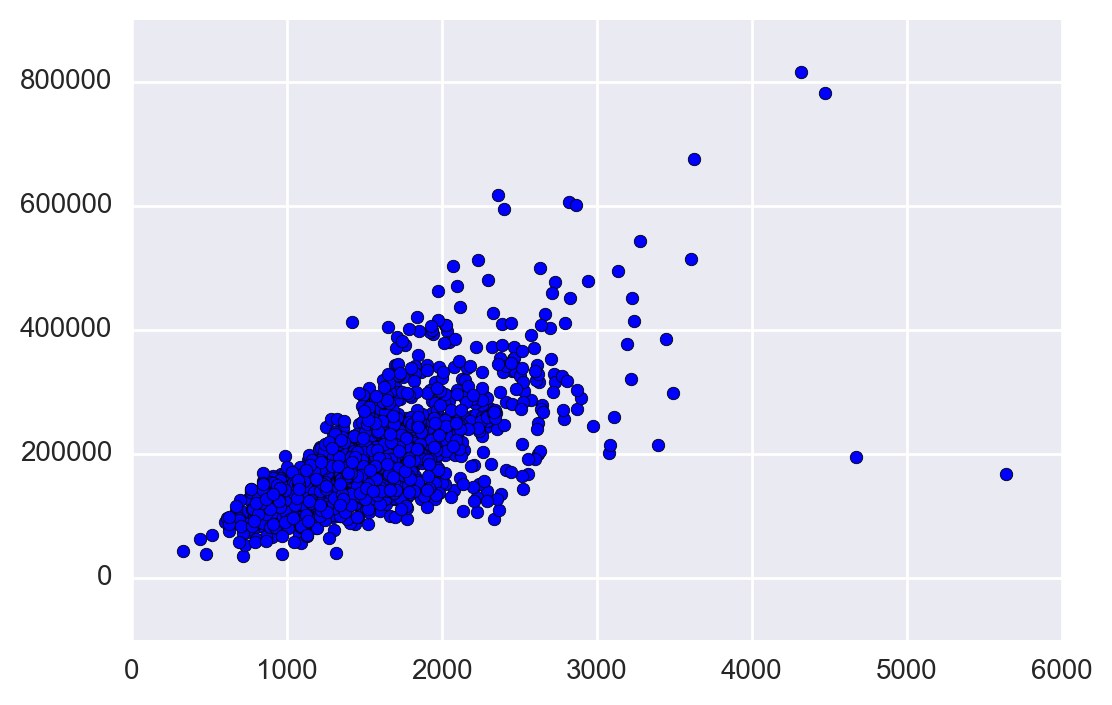

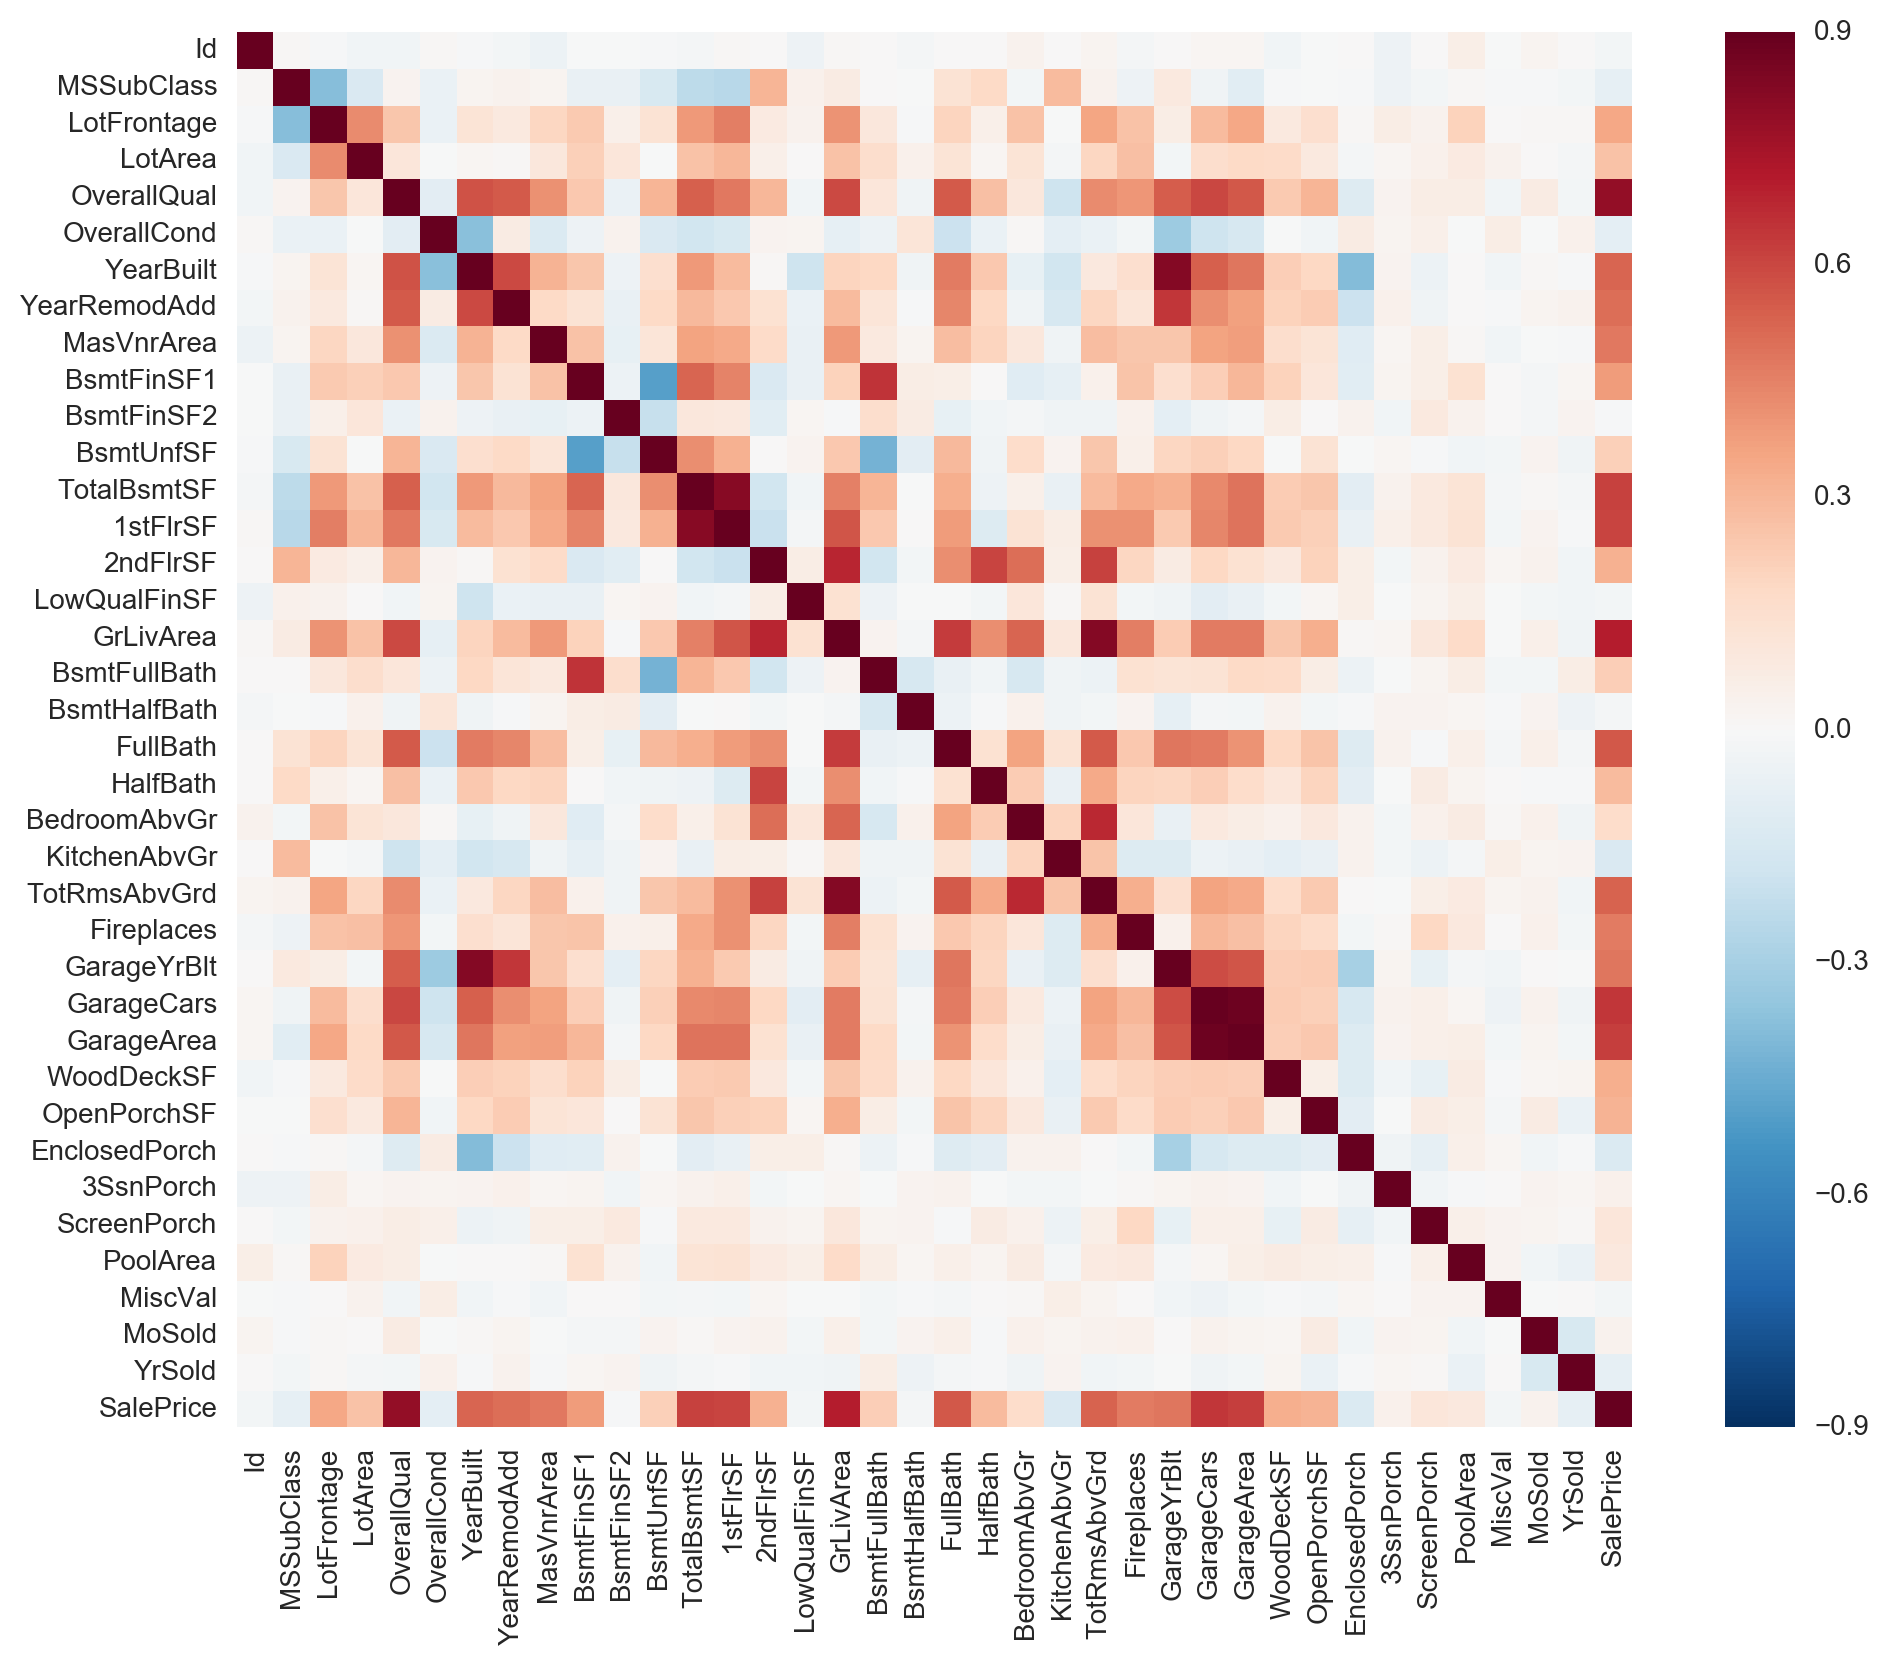

In [36]:
# Plot the correlation of Ground Living Area
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
#Make a correlation map to determine which features are not very correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [37]:
corrmat

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.022606
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.082357
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351366
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.265382
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.787774
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.084604
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522890
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.501783
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.476032
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.383484
